# Store your information

Store this \*.ipynb at a Folder,

and Store 'user-site-export' Folder inside the Folder.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
from collections import OrderedDict
import pprint

In [2]:
folder = "./user-site-export/"
directory = os.listdir("./user-site-export/")
directory = [j for j in directory if "resting_heart_rate" not in j]
s = folder+directory[0]

with open(s) as data_file: 
    data = json.load(data_file)


In [3]:
# the steps are at the 
def step_summary(df):
    df_steps = pd.DataFrame(columns={"date","steps"})
    j = 0
    thedate = pd.to_datetime(df["date"]).min().date()
    maxday = pd.to_datetime(df["date"]).max().date()
    while ( maxday != thedate):
        df_steps.at[j, "date"] = thedate
        df_steps.at[j, "steps"] = df[df["date"]==thedate]["steps"].astype(int).sum()
        j += 1
        thedate += timedelta(days=1)
    df_steps["date"] = pd.to_datetime(df_steps["date"]).dt.date
    return df_steps


In [4]:
# sleep function

def sleep_summary(df_slp):
    cols = df_slp.columns
    df = pd.DataFrame(columns=cols)
    j = 0
    thedate = pd.to_datetime(df_slp["date"]).min().date()
    maxday = pd.to_datetime(df_slp["date"]).max().date()
    cols = cols.drop("date")
    while ( maxday != thedate ):
        df.at[j, "date"] = thedate
        for i in cols:
            try:
                if "start" in i:
                    df.at[j, i] = df_slp[df_slp["date"]==thedate][i].dropna().min()
                elif "end" in i:
                    df.at[j, i] = df_slp[df_slp["date"]==thedate][i].dropna().max()
                else:
                    df.at[j, i] = df_slp[df_slp["date"]==thedate][i].dropna().astype(float).sum()
            except:
                try:
                    df.at[j, i] = df_slp[df_slp["date"]==thedate][i].dropna().astype(str).sum()
                except:
                    df.at[j, i] = df_slp[df_slp["date"]==thedate][i].dropna()
        j += 1
        thedate += timedelta(days=1)
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df['startTime'] = pd.to_datetime(df['startTime'])
    df['endTime'] = pd.to_datetime(df["endTime"])
    return df

#df_slp2 = sleep_summary(df_slp)
#df_slp2

In [5]:

def heartrate_summary(df_hr, category="day"):
    if "value.confidence" in df_hr.columns:
        df_hr = df_hr.rename(columns={"value.confidence":"bpm.confidence"})
    cols = df_hr.columns
    df_hrs = pd.DataFrame(columns={"date","dateTime", "value.bpm", "bpm.confidence", "maxbpm", "minbpm"})
    j = 0
   
    # 
    mindate = pd.to_datetime(df_hr["dateTime"]).min()
    maxdate = pd.to_datetime(df_hr["dateTime"]).max()
    
    if category=="minute":
        mindate = datetime.datetime(mindate.year, mindate.month, mindate.day, mindate.hour, mindate.minute)
        maxdate = datetime.datetime(maxdate.year, maxdate.month, maxdate.day, maxdate.hour, maxdate.minute)
        t_difference = 1
    elif category == "hour":
        mindate = datetime.datetime(mindate.year, mindate.month, mindate.day, mindate.hour)
        maxdate = datetime.datetime(maxdate.year, maxdate.month, maxdate.day, maxdate.hour)
        t_difference = 60
    else:
        mindate = datetime.datetime(mindate.year, mindate.month, mindate.day)
        maxdate = datetime.datetime(maxdate.year, maxdate.month, maxdate.day)
        t_difference = 1440
    
    j=0
    while ( maxdate != mindate ):
        df_hrs.at[j, "dateTime"] = mindate
        df_hrs.at[j, "value.bpm"] = df_hr[(pd.to_datetime(df_hr["dateTime"]) > mindate) & (pd.to_datetime(df_hr["dateTime"]) < (mindate + timedelta(minutes=t_difference)))]["value.bpm"].mean()
        df_hrs.at[j, "bpm.confidence"] = df_hr[(pd.to_datetime(df_hr["dateTime"]) > mindate) & (pd.to_datetime(df_hr["dateTime"]) < (mindate + timedelta(minutes=t_difference)))]["bpm.confidence"].fillna(0).mean()
        df_hrs.at[j, "maxbpm"] = df_hr[(pd.to_datetime(df_hr["dateTime"]) > mindate) & (pd.to_datetime(df_hr["dateTime"]) < (mindate + timedelta(minutes=t_difference)))]["value.bpm"].max()
        df_hrs.at[j, "minbpm"] = df_hr[(pd.to_datetime(df_hr["dateTime"]) > mindate) & (pd.to_datetime(df_hr["dateTime"]) < (mindate + timedelta(minutes=t_difference)))]["value.bpm"].min()
        mindate += timedelta(minutes=t_difference)
        j += 1

    df_hrs["date"] = pd.to_datetime(df_hrs["dateTime"]).dt.date
#    df_hrs.to_csv('out_heartrate_hour.csv',index=False)
    return df_hrs


#df_hr2 = heartrate_summary(df_hr, "day")
#df_hr2

In [6]:
def exercise_summary(df):

    # cleansing the data
    df['date'] = pd.to_datetime(df['startTime']).dt.date
    df['EXstartTime'] = pd.to_datetime(df['startTime'])
    df = df.rename(columns={"duration":"EXduration"})
    dropcols = ['activityLevel', 'activityName', 'calories', 'elevationGain', 'hasGps','heartRateZones', 'lastModified',
                'logId', 'logType','manualValuesSpecified.calories', 'manualValuesSpecified.distance', 'manualValuesSpecified.steps', 
                'originalDuration', 'originalStartTime', 'shouldFetchDetails','startTime', 'steps',
                'source.url','source.id','source.name','source.type',
                     ]
    for i in dropcols:
        try:
            df = df.drop(columns=i)
        except:
            print(i, "can't drop")

    # day by day lines
    df_ex = pd.DataFrame(columns={'activeDuration', 'activityTypeId', 'averageHeartRate', 'EXduration', 'date', 'EXstartTime'})

    mindate = pd.to_datetime(df["EXstartTime"]).min()
    maxdate = pd.to_datetime(df["EXstartTime"]).max()

    mindate = datetime.datetime(mindate.year, mindate.month, mindate.day)
    maxdate = datetime.datetime(maxdate.year, maxdate.month, maxdate.day)
    t_difference = 1440

    j=0
    while ( maxdate != mindate ):
        df_ex.at[j, "date"] = mindate
        df_ex.at[j, "EXstartTime"] = df[(pd.to_datetime(df["EXstartTime"]) > mindate) & (pd.to_datetime(df["EXstartTime"]) < (mindate + timedelta(minutes=t_difference)))]["EXstartTime"].max()
        df_ex.at[j, "activeDuration"] = df[(pd.to_datetime(df["EXstartTime"]) > mindate) & (pd.to_datetime(df["EXstartTime"]) < (mindate + timedelta(minutes=t_difference)))]["activeDuration"].sum()
        df_ex.at[j, "averageHeartRate"] = df[(pd.to_datetime(df["EXstartTime"]) > mindate) & (pd.to_datetime(df["EXstartTime"]) < (mindate + timedelta(minutes=t_difference)))]["averageHeartRate"].mean()
        df_ex.at[j, "EXduration"] = df[(pd.to_datetime(df["EXstartTime"]) > mindate) & (pd.to_datetime(df["EXstartTime"]) < (mindate + timedelta(minutes=t_difference)))]["EXduration"].sum()
        # only one activity type id selected.
        df_ex.at[j, "activityTypeId"] = df[(pd.to_datetime(df["EXstartTime"]) > mindate) & (pd.to_datetime(df["EXstartTime"]) < (mindate + timedelta(minutes=t_difference)))]["activityTypeId"].max()
        mindate += timedelta(minutes=t_difference)
        j += 1

    return df_ex


In [7]:
def readandstore(directory, folder, category):
    df2 = pd.DataFrame()
    # k is a list of JSON file name.
    k = [j for j in directory if category in j]

    for i in k :
        s = folder+i
        with open(s) as data_file:
#            data = json.dumps(data_file)
            data = json.load(data_file)
        df = pd.io.json.json_normalize(data, errors='ignore').rename(columns={"value":category})
        df2 = df2.append(df)
        #

    if "dateOfSleep" in df2.columns:
        df2 = df2.rename(columns={"dateOfSleep":"dateTime"})
    
    if "dateTime" in df2.columns:
        df2["dateTime"] = pd.to_datetime(df2["dateTime"])
        df2["date"] = pd.to_datetime(df2["dateTime"]).dt.date    
    
    if category=='sleep':
        df2 = sleep_summary(df2)

    elif category=='steps':
        df2 = step_summary(df2)
        
    elif category=='heart_rate-':
        df2 = heartrate_summary(df2, "day")

    elif category=='exercise':
        df2 = exercise_summary(df2)
        
    if "dateTime" in df2.columns:
        df2 = df2.drop(columns="dateTime")

    if "date" in df2.columns:
        df2["date"] = pd.to_datetime(df2["date"])
    else:
        print(category)
    
    return df2


In [8]:
cols = [
#    'altitude',
#        'badge.json',
#        'calories',
#        'demographic_vo2_max',
#        'distance',
        'exercise', # if you are using Windows machine, might have Unicode Error!!
        'heart_rate-',
        'time_in_heart_rate_zones',
#        'height',
        'lightly_active_minutes',
        'moderately_active_minutes',
        'sedentary_minutes',
        'very_active_minutes',
        'sleep',
        'steps',
       ]


if you need an individual dataframe, try below:

In [ ]:
for i in cols:
    print("df_"+i.replace("-","")+" = readandstore(directory, folder,\'"+ i+"\')")

#df_exercise = readandstore(directory, folder,'exercise')
#df_heart_rate = readandstore(directory, folder,'heart_rate-')
#df_time_in_heart_rate_zones = readandstore(directory, folder,'time_in_heart_rate_zones')
#df_lightly_active_minutes = readandstore(directory, folder,'lightly_active_minutes')
#df_moderately_active_minutes = readandstore(directory, folder,'moderately_active_minutes')
#df_sedentary_minutes = readandstore(directory, folder,'sedentary_minutes')
#df_very_active_minutessleep = readandstore(directory, folder,'very_active_minutes')
#df_sleep = readandstore(directory, folder,'sleep')
#df_steps = readandstore(directory, folder,'steps')


In [ ]:
df_exercise = readandstore(directory, folder,'exercise')
df_heart_rate = readandstore(directory, folder,'heart_rate-')
df_time_in_heart_rate_zones = readandstore(directory, folder,'time_in_heart_rate_zones')
df_lightly_active_minutes = readandstore(directory, folder,'lightly_active_minutes')
df_moderately_active_minutes = readandstore(directory, folder,'moderately_active_minutes')
df_sedentary_minutes = readandstore(directory, folder,'sedentary_minutes')
df_very_active_minutes = readandstore(directory, folder,'very_active_minutes')
df_sleep = readandstore(directory, folder,'sleep')
df_steps = readandstore(directory, folder,'steps')

Otherwise, you will get one big dataframe.

In [9]:
df = pd.DataFrame(columns={"date"})
for i in cols:
    df2 = readandstore(directory, folder, i)
    try:
        df=pd.merge(df, df2 , on="date", how="outer", sort=False)
    except:
        print("error in ",i)

/root/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [10]:
df

,activeDuration,EXduration,EXstartTime,activityTypeId,date,averageHeartRate,minbpm,bpm.confidence,value.bpm,maxbpm,...,levels.summary.wake.thirtyDayAvgMinutes,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,minutesToFallAsleep,startTime,timeInBed,type,steps
0,4000,14000,2018-08-31 16:59:42,2131,2018-08-31,104,54,2.21948,81.1521,129,...,0,3.87197e+10,1,663,56,0,2018-08-30 23:21:30,720,classicstages,3054
1,0,0,NaT,NaN,2018-09-01,NaN,66,1.95456,92.5224,140,...,0,0,0,0,0,0,NaT,0,0,9266
2,0,0,NaT,NaN,2018-09-02,NaN,56,2.28129,83.1732,125,...,55,1.93778e+10,0,174,47,0,2018-09-02 05:06:30,221,stages,4197
3,3278000,3278000,2018-09-03 10:06:57,90013,2018-09-03,111,57,2.00481,93.0095,147,...,51,1.9388e+10,0,368,26,0,2018-09-03 01:01:30,394,stages,12319
4,0,0,NaT,NaN,2018-09-04,NaN,56,2.19884,80.8466,147,...,0,0,0,0,0,0,NaT,0,0,5872
5,0,0,NaT,NaN,2018-09-05,NaN,60,1.81052,94.6682,143,...,0,0,0,0,0,0,NaT,0,0,16634
6,0,0,NaT,NaN,2018-09-06,NaN,62,1.91337,95.8249,146,...,0,1.94193e+10,0,95,1,0,2018-09-06 04:56:00,96,classic,8737
7,1025000,1025000,2018-09-07 05:01:30,90013,2018-09-07,110,58,2.14482,89.4671,145,...,43,1.94309e+10,0,332,22,0,2018-09-07 02:16:30,354,stages,16355
8,0,0,NaT,NaN,2018-09-08,NaN,57,2.1359,82.5545,142,...,38,1.94405e+10,0,351,30,0,2018-09-08 01:58:00,381,stages,12424
9,1229000,1229000,2018-09-09 10:21:32,90013,2018-09-09,113,55,2.10708,84.5377,137,...,0,3.89006e+10,0,177,3,0,2018-09-09 02:06:30,180,classicclassic,14742


# cleansing data

In [12]:
cols = ['lightly_active_minutes', 'moderately_active_minutes', 'sedentary_minutes', 'very_active_minutes']
for i in cols:
    df[i] = df[i].astype(int)


In [13]:
dropcols = [
#    'value.valuesInZones.BELOW_DEFAULT_ZONE_1',
#    'value.valuesInZones.IN_DEFAULT_ZONE_1',
#    'value.valuesInZones.IN_DEFAULT_ZONE_2',
#    'value.valuesInZones.IN_DEFAULT_ZONE_3',
    'infoCode',
    'levels.data',
    'levels.shortData',
    'levels.summary.deep.thirtyDayAvgMinutes',
    'levels.summary.light.thirtyDayAvgMinutes',
    'levels.summary.rem.thirtyDayAvgMinutes',
    'levels.summary.wake.thirtyDayAvgMinutes',
    'logId',
    'minutesAfterWakeup',
    'minutesAsleep',
    'minutesAwake',
    'minutesToFallAsleep',
    'type',
    'source.id',
    'source.name',
    'source.type',
    'source.url',
    'minutesAfterWakeup',
    'minutesAsleep',
    'minutesAwake',
    'minutesToFallAsleep'
]
for i in dropcols:
    try:
        df = df.drop(columns=i)
    except:
        print(i, "can not drop")
df


source.id can not drop
source.name can not drop
source.type can not drop
source.url can not drop
minutesAfterWakeup can not drop
minutesAsleep can not drop
minutesAwake can not drop
minutesToFallAsleep can not drop


,activeDuration,EXduration,EXstartTime,activityTypeId,date,averageHeartRate,minbpm,bpm.confidence,value.bpm,maxbpm,...,levels.summary.light.minutes,levels.summary.rem.count,levels.summary.rem.minutes,levels.summary.restless.count,levels.summary.restless.minutes,levels.summary.wake.count,levels.summary.wake.minutes,startTime,timeInBed,steps
0,4000,14000,2018-08-31 16:59:42,2131,2018-08-31,104,54,2.21948,81.1521,129,...,310,17,154,2,2,47,55,2018-08-30 23:21:30,720,3054
1,0,0,NaT,NaN,2018-09-01,NaN,66,1.95456,92.5224,140,...,0,0,0,0,0,0,0,NaT,0,9266
2,0,0,NaT,NaN,2018-09-02,NaN,56,2.28129,83.1732,125,...,104,3,39,0,0,11,47,2018-09-02 05:06:30,221,4197
3,3278000,3278000,2018-09-03 10:06:57,90013,2018-09-03,111,57,2.00481,93.0095,147,...,180,7,129,0,0,19,26,2018-09-03 01:01:30,394,12319
4,0,0,NaT,NaN,2018-09-04,NaN,56,2.19884,80.8466,147,...,0,0,0,0,0,0,0,NaT,0,5872
5,0,0,NaT,NaN,2018-09-05,NaN,60,1.81052,94.6682,143,...,0,0,0,0,0,0,0,NaT,0,16634
6,0,0,NaT,NaN,2018-09-06,NaN,62,1.91337,95.8249,146,...,0,0,0,1,1,0,0,2018-09-06 04:56:00,96,8737
7,1025000,1025000,2018-09-07 05:01:30,90013,2018-09-07,110,58,2.14482,89.4671,145,...,130,9,124,0,0,15,22,2018-09-07 02:16:30,354,16355
8,0,0,NaT,NaN,2018-09-08,NaN,57,2.1359,82.5545,142,...,142,12,112,0,0,21,30,2018-09-08 01:58:00,381,12424
9,1229000,1229000,2018-09-09 10:21:32,90013,2018-09-09,113,55,2.10708,84.5377,137,...,0,0,0,3,3,0,0,2018-09-09 02:06:30,180,14742


In [14]:
df["day_name"] = df["date"].dt.day_name()

In [15]:
df.columns

Index(['activeDuration', 'EXduration', 'EXstartTime', 'activityTypeId', 'date',
       'averageHeartRate', 'minbpm', 'bpm.confidence', 'value.bpm', 'maxbpm',
       'value.valuesInZones.BELOW_DEFAULT_ZONE_1',
       'value.valuesInZones.IN_DEFAULT_ZONE_1',
       'value.valuesInZones.IN_DEFAULT_ZONE_2',
       'value.valuesInZones.IN_DEFAULT_ZONE_3', 'lightly_active_minutes',
       'moderately_active_minutes', 'sedentary_minutes', 'very_active_minutes',
       'duration', 'efficiency', 'endTime', 'levels.summary.asleep.count',
       'levels.summary.asleep.minutes', 'levels.summary.awake.count',
       'levels.summary.awake.minutes', 'levels.summary.deep.count',
       'levels.summary.deep.minutes', 'levels.summary.light.count',
       'levels.summary.light.minutes', 'levels.summary.rem.count',
       'levels.summary.rem.minutes', 'levels.summary.restless.count',
       'levels.summary.restless.minutes', 'levels.summary.wake.count',
       'levels.summary.wake.minutes', 'startTime', '

In [16]:
cols = ['minbpm', 'value.bpm', 'maxbpm',
       'value.valuesInZones.BELOW_DEFAULT_ZONE_1',
       'value.valuesInZones.IN_DEFAULT_ZONE_1',
       'value.valuesInZones.IN_DEFAULT_ZONE_2',
       'value.valuesInZones.IN_DEFAULT_ZONE_3', 'lightly_active_minutes',
       'moderately_active_minutes', 'sedentary_minutes', 'very_active_minutes',
       'efficiency', 'levels.summary.asleep.count',
       'levels.summary.asleep.minutes', 'levels.summary.awake.count',
       'levels.summary.awake.minutes', 'levels.summary.deep.count',
       'levels.summary.deep.minutes', 'levels.summary.light.count',
       'levels.summary.light.minutes', 'levels.summary.rem.count',
       'levels.summary.rem.minutes',
       'levels.summary.restless.count', 'levels.summary.restless.minutes',
       'levels.summary.wake.count', 'levels.summary.wake.minutes',
        'timeInBed','steps',
       ]
        

In [17]:
df.to_csv('out_fitbitdata.csv',index=False)

In [21]:
df

,activeDuration,EXduration,EXstartTime,activityTypeId,date,averageHeartRate,minbpm,bpm.confidence,value.bpm,maxbpm,...,levels.summary.rem.count,levels.summary.rem.minutes,levels.summary.restless.count,levels.summary.restless.minutes,levels.summary.wake.count,levels.summary.wake.minutes,startTime,timeInBed,steps,day_name
0,4000,14000,2018-08-31 16:59:42,2131,2018-08-31,104,54,2.21948,81.1521,129,...,17,154,2,2,47,55,2018-08-30 23:21:30,720,3054,Friday
1,0,0,NaT,NaN,2018-09-01,NaN,66,1.95456,92.5224,140,...,0,0,0,0,0,0,NaT,0,9266,Saturday
2,0,0,NaT,NaN,2018-09-02,NaN,56,2.28129,83.1732,125,...,3,39,0,0,11,47,2018-09-02 05:06:30,221,4197,Sunday
3,3278000,3278000,2018-09-03 10:06:57,90013,2018-09-03,111,57,2.00481,93.0095,147,...,7,129,0,0,19,26,2018-09-03 01:01:30,394,12319,Monday
4,0,0,NaT,NaN,2018-09-04,NaN,56,2.19884,80.8466,147,...,0,0,0,0,0,0,NaT,0,5872,Tuesday
5,0,0,NaT,NaN,2018-09-05,NaN,60,1.81052,94.6682,143,...,0,0,0,0,0,0,NaT,0,16634,Wednesday
6,0,0,NaT,NaN,2018-09-06,NaN,62,1.91337,95.8249,146,...,0,0,1,1,0,0,2018-09-06 04:56:00,96,8737,Thursday
7,1025000,1025000,2018-09-07 05:01:30,90013,2018-09-07,110,58,2.14482,89.4671,145,...,9,124,0,0,15,22,2018-09-07 02:16:30,354,16355,Friday
8,0,0,NaT,NaN,2018-09-08,NaN,57,2.1359,82.5545,142,...,12,112,0,0,21,30,2018-09-08 01:58:00,381,12424,Saturday
9,1229000,1229000,2018-09-09 10:21:32,90013,2018-09-09,113,55,2.10708,84.5377,137,...,0,0,3,3,0,0,2018-09-09 02:06:30,180,14742,Sunday


In [18]:
import matplotlib.pylab as plt
%matplotlib inline

CPU times: user 6.66 s, sys: 44.1 ms, total: 6.7 s
Wall time: 6.81 s


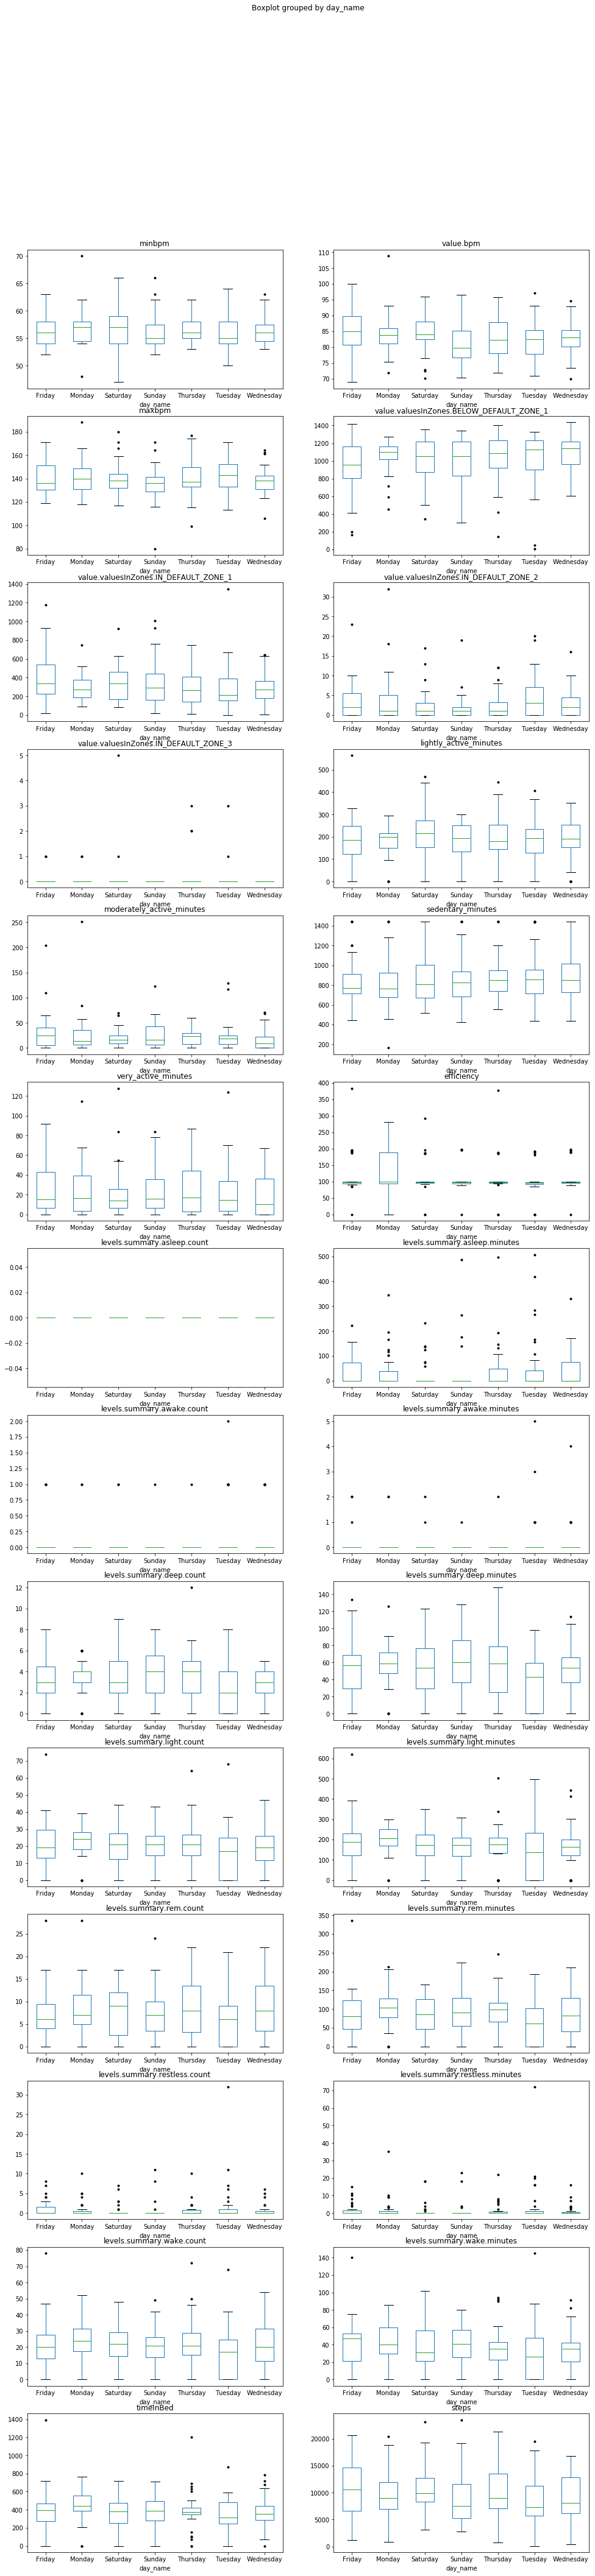

In [19]:
import math
r = math.ceil(len(cols)/2)
c = 2 
fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(8*c, 5*r))

j=0
k=0

for i in cols:
    try:
        df.boxplot(i, "day_name", grid=False, sym='k.', ax=axes[j, k])
        k = 1 - k
        if k == 0:
            j += 1
    except:
        print("error in", i)